In [ ]:
%pip install jax
%pip install numpy
%pip install matplotlib
%pip install xminigrid

In [2]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np

import timeit
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

import xminigrid

In [ ]:
class TimeStep(struct.PyTreeNode):
    # hidden environment state, such as grid, agent, goal, etc
    state: State

    # similar to the dm_env enterface
    step_type: StepType
    reward: jax.Array
    discount: jax.Array
    observation: jax.Array

In [4]:
def show_img(img, dpi=32):
  plt.figure(dpi=dpi)
  plt.axis('off')
  plt.imshow(img)

Observation shape: (7, 7, 2)
Num actions: 6
TimeStep shapes: TimeStep(state=State(key=(), step_num=(), grid=(8, 8, 2), agent=AgentState(position=(2,), direction=(), pocket=(2,)), goal_encoding=(5,), rule_encoding=(1, 7), carry=EnvCarry()), step_type=(), reward=(), discount=(), observation=(7, 7, 2))


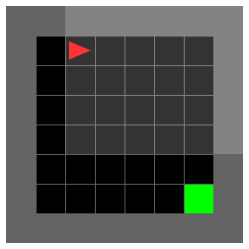

In [5]:
key = jax.random.key(0)
key, reset_key = jax.random.split(key)

env, env_params = xminigrid.make('MiniGrid-Empty-8x8')
print("Observation shape:", env.observation_shape(env_params))
print("Num actions:", env.num_actions(env_params))

timestep = jax.jit(env.reset)(env_params, reset_key)
timestep = jax.jit(env.step)(env_params, timestep, action=0)

print("TimeStep shapes:", jtu.tree_map(jnp.shape, timestep))

show_img(env.render(env_params, timestep), dpi=64)

In [6]:
print(env_params)

EnvParams(height=8, width=8, view_size=7, max_steps=256, render_mode='rgb_array')


In [7]:
from xminigrid.wrappers import GymAutoResetWrapper

def build_rollout(env, env_params, num_steps):
  def rollout(rng):
    def _step_fn(carry, _):
      rng, timestep = carry
      rng, _rng = jax.random.split(rng)
      action = jax.random.randint(_rng, shape=(), minval=0, maxval=env.num_actions(env_params))

      timestep = env.step(env_params, timestep, action)

      return (rng, timestep), timestep

    rng, _rng = jax.random.split(rng)
    timestep = env.reset(env_params, _rng)
    rng, transitions = jax.lax.scan(_step_fn, (rng, timestep), None, length=num_steps)

    return transitions
  return rollout

In [12]:
env, env_params = xminigrid.make("MiniGrid-EmptyRandom-8x8")
env = GymAutoResetWrapper(env)

rollout_fn = jax.jit(build_rollout(env, env_params, num_steps=1000))

rollout = rollout_fn(jax.random.key(0))

In [13]:
print("Transitions shapes: \n", jtu.tree_map(jnp.shape, rollout))

Transitions shapes: 
 TimeStep(state=State(key=(1000,), step_num=(1000,), grid=(1000, 8, 8, 2), agent=AgentState(position=(1000, 2), direction=(1000,), pocket=(1000, 2)), goal_encoding=(1000, 5), rule_encoding=(1000, 1, 7), carry=EnvCarry()), step_type=(1000,), reward=(1000,), discount=(1000,), observation=(1000, 7, 7, 2))


In [20]:
images = []

for i in range(1000):
    timestep = jtu.tree_map(lambda x: x[i], rollout)
    images.append(env.render(env_params, timestep))

imageio.mimsave("example_rollout.mp4", images, fps=32, format="mp4")


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/lib/python3.11/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(


In [21]:
from IPython.display import Video

Video("example_rollout.mp4", embed=True)

In [23]:
vmap_rollout_fn = jax.jit(jax.vmap(build_rollout(env, env_params, num_steps=1000)))
rngs = jax.random.split(jax.random.key(0), num=1024)

vmap_rollout = vmap_rollout_fn(rngs)

print("Transitions shapes: \n", jtu.tree_map(jnp.shape, vmap_rollout))

Transitions shapes: 
 TimeStep(state=State(key=(1024, 1000), step_num=(1024, 1000), grid=(1024, 1000, 8, 8, 2), agent=AgentState(position=(1024, 1000, 2), direction=(1024, 1000), pocket=(1024, 1000, 2)), goal_encoding=(1024, 1000, 5), rule_encoding=(1024, 1000, 1, 7), carry=EnvCarry()), step_type=(1024, 1000), reward=(1024, 1000), discount=(1024, 1000), observation=(1024, 1000, 7, 7, 2))
